# Traffic Signs Classification

## Problem Description

In this project we are going to train a model to distinguish traffic signs from 43 different categories.

We will orient on edge deployment and create a model that will be served as a part of mobile application -  so we should keep in mind the size of the model, it's compatibility with different operating systems and the convenience of deployment.

We will use Transfer Learning and utilize pre-trained MobileNetV3*Large* model. We also will build a small CNN and compare which one of this models suits better for the task at hand.

Most suitable model will be converted into two formats:
- "mlmodel" to use in XCode and create iOS Apps.
- "tflite" to use with ML Kit and create apps for either OS.

## Set Up

### Importing Libraries and Updating Settings

In [ ]:
! pip install --quiet --upgrade coremltools

import tensorflow as tf
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import coremltools as ct

## Getting the Data

### About the Data

We'll use the [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) Dataset from Kaggle.

- It is suited for single-image, multi-class classification problem.
- Includes 43 classes.
- Contains more than 50,000 images in total.

### Downloading the Data

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OdKwLiBAXt_ICxaaw4U-AXGQ8J9Y9E70' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OdKwLiBAXt_ICxaaw4U-AXGQ8J9Y9E70" -O GTSRB.zip && rm -rf /tmp/cookies.txt
!unzip GTSRB.zip &> /dev/null
!rm -rf __MACOSX & rm -rf GTSRB.zip

### Loading Data into Train and Test Folders

In [ ]:
TRAIN_DATA_DIRECTORY = "GTSRB/Train/"
TEST_DATA_DIRECTORY = "GTSRB/Test/"
NUMBER_OF_CLASSES = 43

## Visualising Data

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }


CLASS_NAMES = [str(i) for i in classes.keys()]

Found 43 files belonging to 43 classes.


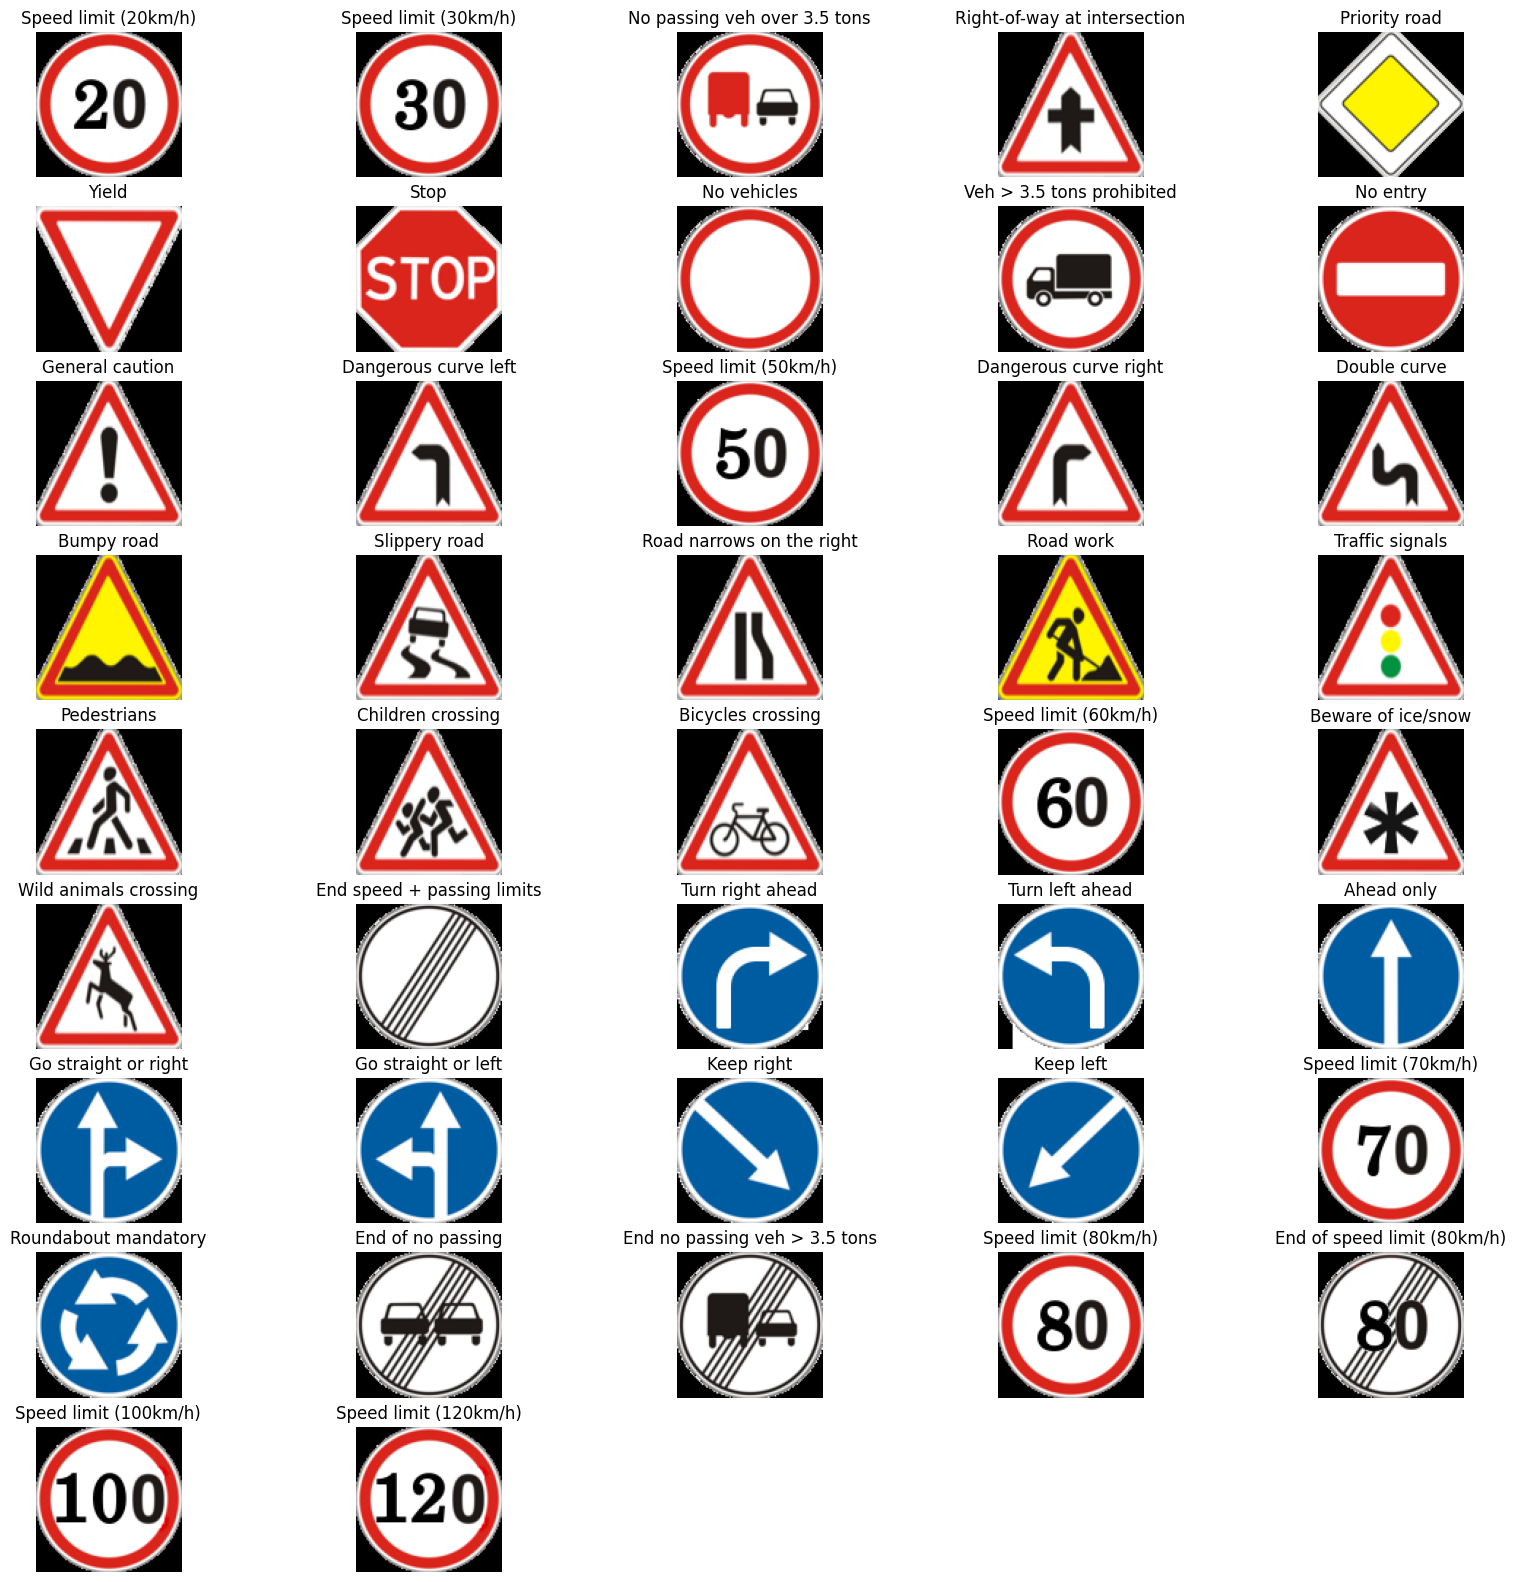

In [ ]:
traffic_signs_meta = "GTSRB/Meta/"

sample_images = tf.keras.utils.image_dataset_from_directory(
    directory = traffic_signs_meta,
    image_size = (100, 100),
    shuffle = False,
    class_names = CLASS_NAMES,
    batch_size = 43
)


plt.figure(figsize=(20, 20))
for images, labels in sample_images.take(1):
  for i in range(42):
    ax = plt.subplot(9, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[int(labels[i])])
    plt.axis("off")

del([sample_images, images, labels])

## Splitting the Data (Creating Generators)

We will split the test data in half and use one part of it as Validation Set.

To do this, we'll divide the data from test folder into two subsets - train and validation. Both this subsets will be used for model evaluation - "training" subset as Validation Set and "validation" subset as the Test Set.

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224
BATCH_SIZE = 128

train_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TRAIN_DATA_DIRECTORY,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

validation_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TEST_DATA_DIRECTORY,
    validation_split = 0.5,
    subset = "training",
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

test_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TEST_DATA_DIRECTORY,
    validation_split = 0.5,
    subset = "validation",
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.
Using 6315 files for training.
Found 12630 files belonging to 43 classes.
Using 6315 files for validation.


## Creating a Model using Transfer Learning

### Downloading the Base Model

Our base model will be MobileNetV3Large.

In [ ]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top = False, include_preprocessing = True)

for layer in base_model.layers[:]:
    layer.trainable = False

### Instantiating the Model

In [ ]:
inputs = tf.keras.layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units = 64, activation = tf.nn.relu)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(rate = 0.25)(x)
predictions = tf.keras.layers.Dense(units = NUMBER_OF_CLASSES, activation = tf.nn.softmax)(x)

model = tf.keras.Model(inputs = inputs, outputs = predictions)


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy()
)

In [ ]:
model.fit(
    x = train_data_generator,
    epochs = 25,
    validation_data = validation_data_generator
)

Epoch 1/25
307/307 [==============================] - 67s 192ms/step - loss: 0.7852 - categorical_accuracy: 0.8507 - val_loss: 0.5655 - val_categorical_accuracy: 0.8850
Epoch 2/25
307/307 [==============================] - 58s 187ms/step - loss: 0.1247 - categorical_accuracy: 0.9951 - val_loss: 0.4309 - val_categorical_accuracy: 0.9140
Epoch 3/25
307/307 [==============================] - 58s 185ms/step - loss: 0.0569 - categorical_accuracy: 0.9994 - val_loss: 0.3738 - val_categorical_accuracy: 0.9221
Epoch 4/25
307/307 [==============================] - 58s 186ms/step - loss: 0.0335 - categorical_accuracy: 0.9998 - val_loss: 0.3428 - val_categorical_accuracy: 0.9284
Epoch 5/25
307/307 [==============================] - 58s 188ms/step - loss: 0.0222 - categorical_accuracy: 1.0000 - val_loss: 0.3272 - val_categorical_accuracy: 0.9264
Epoch 6/25
307/307 [==============================] - 60s 192ms/step - loss: 0.0161 - categorical_accuracy: 1.0000 - val_loss: 0.2959 - val_categorical_acc

### Evaluating Model

In [ ]:
model.evaluate(x = test_data_generator)

50/50 [==============================] - 8s 149ms/step - loss: 0.2129 - categorical_accuracy: 0.9403


[0.21293461322784424, 0.9403008818626404]

We were able to achieve 94% accuracy on the Validation Set.

If we look closely on the training process we can see, that, starting from 19th epoch the model had little problem converging further and started to "jump around", even though learning rate is not so big. Setting a learning rate decay schedule for this model might be a good practice.

#### Checking Model's Summary

In [ ]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 flatten_12 (Flatten)        (None, 47040)             0         
                                                                 
 dense_24 (Dense)            (None, 64)                3010624   
                                                                 
 batch_normalization_12 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 64)                0  

We can see that the size of trained model is near 23 MB. Not very heavy for such complicated network.

## Creating a Custom CNN

### Changing Image Input Size and Re-splitting the Data

In [ ]:
IMAGE_WIDTH, IMAGE_HEIGHT = 24, 24
BATCH_SIZE = 128

train_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TRAIN_DATA_DIRECTORY,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

validation_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TEST_DATA_DIRECTORY,
    validation_split = 0.5,
    subset = "training",
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

test_data_generator = tf.keras.utils.image_dataset_from_directory(
    directory = TEST_DATA_DIRECTORY,
    validation_split = 0.5,
    subset = "validation",
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 41,
    class_names = CLASS_NAMES,
    label_mode = "categorical"
)

Found 39209 files belonging to 43 classes.
Found 12630 files belonging to 43 classes.
Using 6315 files for training.
Found 12630 files belonging to 43 classes.
Using 6315 files for validation.


### Instantiating the Model

In [ ]:
inputs = tf.keras.layers.Input(shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = tf.keras.layers.Rescaling(scale = 1. / 255)(inputs)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = "valid", activation = tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = "valid", activation = tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units = 64)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
predictions = tf.keras.layers.Dense(units = NUMBER_OF_CLASSES, activation = tf.nn.softmax)(x)

model2 = tf.keras.Model(inputs = inputs, outputs = predictions)

In [ ]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy()
)

In [ ]:
model2.fit(
    x = train_data_generator,
    epochs = 25,
    validation_data = validation_data_generator
)

Epoch 1/25
307/307 [==============================] - 12s 34ms/step - loss: 1.4201 - categorical_accuracy: 0.6791 - val_loss: 1.4831 - val_categorical_accuracy: 0.8822
Epoch 2/25
307/307 [==============================] - 11s 35ms/step - loss: 0.1640 - categorical_accuracy: 0.9754 - val_loss: 0.2951 - val_categorical_accuracy: 0.9335
Epoch 3/25
307/307 [==============================] - 11s 35ms/step - loss: 0.0529 - categorical_accuracy: 0.9931 - val_loss: 0.2034 - val_categorical_accuracy: 0.9476
Epoch 4/25
307/307 [==============================] - 14s 45ms/step - loss: 0.0243 - categorical_accuracy: 0.9978 - val_loss: 0.1823 - val_categorical_accuracy: 0.9498
Epoch 5/25
307/307 [==============================] - 11s 34ms/step - loss: 0.0132 - categorical_accuracy: 0.9992 - val_loss: 0.2089 - val_categorical_accuracy: 0.9433
Epoch 6/25
307/307 [==============================] - 11s 34ms/step - loss: 0.0104 - categorical_accuracy: 0.9991 - val_loss: 0.1754 - val_categorical_accuracy:

### Evaluating Model

In [ ]:
model2.evaluate(x = test_data_generator)

50/50 [==============================] - 2s 37ms/step - loss: 0.1568 - categorical_accuracy: 0.9645


[0.15681448578834534, 0.9645289182662964]

This model yielded more accurate results - 96% accuracy on the Test Set and almost 97% accuracy on the Validation Set on last epochs of training.

It also had a little trouble converging to the minimum - although mostly training process was smooth, we can see a significant decay in performance on 13th epoch and a few more drawdowns little later.

#### Checking Model's Summary

In [ ]:
model2.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 24, 24, 3)]       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 24, 24, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 24, 24, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 12, 12, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                    

This model turned out to be extra light-weight - only 408 KB.

## Choosing Model

We have two trained models to choose from:

First model is more complicated - it is larger and heavier, but, despite that, it does not show better results.

One of it's main disadvantages is the input size - Mobile Net V3 requires input images of size 224x224. That makes the model more heavy and more needy in terms of RAM during training.
Besides that, the major part of images in the dataset did not have size larger than 27x27. So all images were forcibly inflated to match required input size.

On the other hand, with custom CNN model we could freely choose the input size, so we were able to shrink both the need for computational resources and the size of final model, all with keeping comfortable image size.

This model also happen to be more accurate on validation data, so lets stop our choice here and prepare it for further use in possible applications.

## Saving Model

### mlmodel with CoreMLTools

Core ML Tools allow us to specify two types of inputs for the model `MLMultiArray` and `ImageType`.

We will use `ImageType`, since our input type always will be an image. This type of input is also more convenient, since it allows automatic resizing of any input images to required size. It's only drawback is that it restricts us from loading the images in batches.

We will specify that expected input to this model is 1 RGB image of the size 24 x 24.

We also will specify the type in which we want to convert our model.

Core ML Tools supports two types of models to convert to - newer type `ML Program` and older type `Neural Network`.

`Ml Program` will work only with deployment targets not older than `iOS15`, `macOS12`, `watchOS8`, or `tvOS15`.

So, since we want our model to be compatible with as many supported devices as possible, we choose a `Neaural Network` type and also set a minimum deployment target to the oldest supported version - `iOS13`.

In [ ]:
classifier_config = ct.ClassifierConfig(class_labels = CLASS_NAMES)

image_input = ct.ImageType(shape = (1, IMAGE_WIDTH, IMAGE_HEIGHT, 3))

converted_model = ct.convert(model = model2,
                             inputs = [image_input],
                             classifier_config = classifier_config,
                             convert_to = "neuralnetwork",
                             minimum_deployment_target = ct.target.iOS13
                             )


converted_model.save("converted_model.mlmodel")

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 64/64 [00:00<00:00, 1173.61 ops/s]


### TFLite

TFLite does not require any specifications, so we can just save the model as is, without any predefined parameters.

In [ ]:
lite_converter = tf.lite.TFLiteConverter.from_keras_model(model2)

tflite_model = lite_converter.convert()

with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

## Making Predictions

The most important peculiarity of this model is that it will make it's very best predictions *particularly* for bad quality images (on which it was trained).

In the meantime, majority of high resolution images will be classified as `Speed limit (30km/h)`

You can check how model makes predictions for both good and bad quality images by running the code in the next cell.

Try to change values into `sign_class` variable to see predictions for different classes.

1/1 [==============================] - 0s 28ms/step


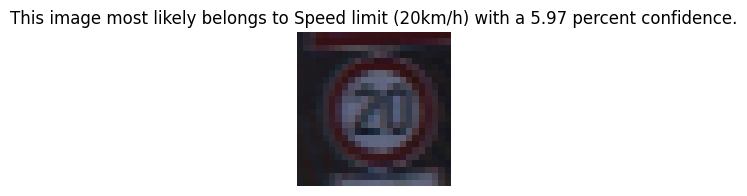

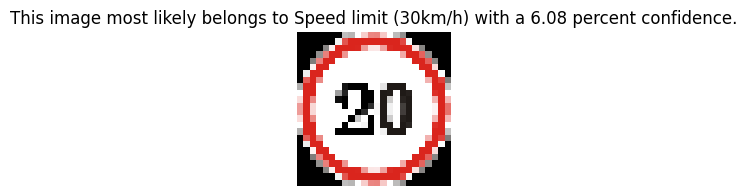

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nxmbLSFp0m8nEy9pN8Tw67QRBJyPTRKx' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nxmbLSFp0m8nEy9pN8Tw67QRBJyPTRKx" -O ts_classifier_files.zip && rm -rf /tmp/cookies.txt
!unzip ts_classifier_files.zip &> /dev/null
!rm -rf __MACOSX & rm -rf ts_classifier_files.zip

import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt


sign_class = "0"


model = tf.keras.models.load_model('model2.keras')
classes = joblib.load("classes.pkl")

image = sign_class + ".png"
img_gq_path = os.path.join("ts_classifier_files/Predictions/GQ/", image)
img_bq_path = os.path.join("ts_classifier_files/Predictions/BQ/", image)

img_paths = [img_bq_path, img_gq_path]

for path in img_paths:
  img = tf.keras.utils.load_img(path, target_size=(24, 24))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  plt.figure(figsize = (2, 2))
  plt.imshow(img)
  plt.title("This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score)))
  plt.axis("off")


Found 43 files belonging to 43 classes.


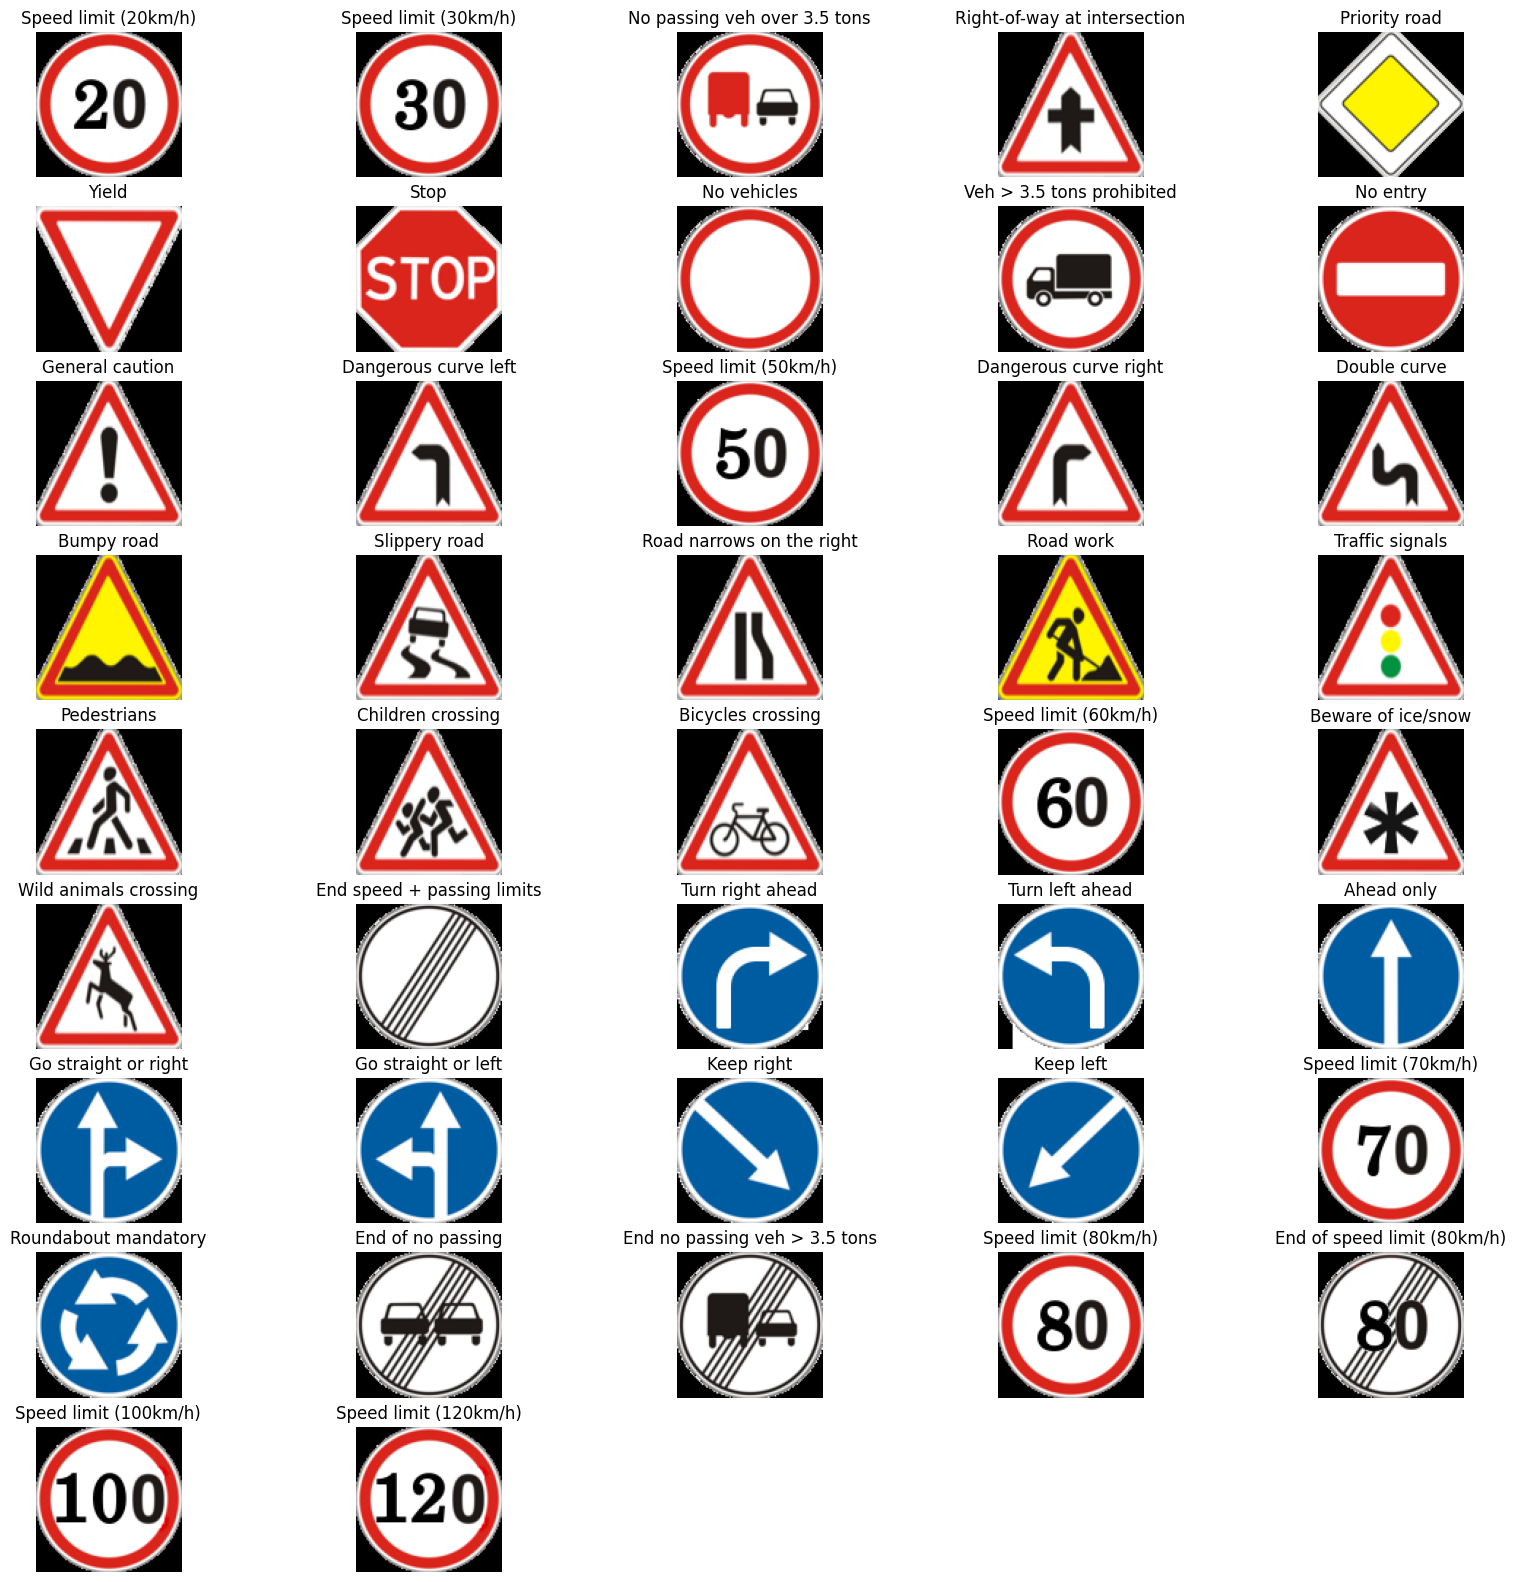

In [ ]:
# reminder of traffic sign classes